# Introduction

In the following notebook, I will be performing an EDA of some Airbnb data in the San Francisco area. This data pertains to the last calendar year, which at the time of this analysis would be December 2018 - December 2019.

In the following analysis, I will be looking to explore the data and answer the following questions:

- Machine learning target variables distributions
- Growth of Airbnb rental properties by neighborhood in the SF area
- Average per night rental based upon property type


*GitHub Repo References*
The raw data files can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Data/01_Raw).

The raw data aggregation scripts can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/01.%20Raw%20Data%20Aggregation%20Scripts).

The data cleaning scripts used to tidy the raw data aggregation can be found [here](https://github.com/KishenSharma6/Airbnb-SF_ML_-_Text_Analysis/tree/master/Project%20Codes/02.%20Data%20Cleaning%20Scripts).

In [38]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
#Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [40]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [41]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [42]:
#Read in Airbnb Listings Data
listings = pd.read_csv(path + '01_04_2020_Listings_Cleaned.csv',index_col=0, low_memory=True, sep=',')

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '01_04_2020_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

reviews = pd.read_csv(path + '01_04_2020_Reviews_Cleaned.csv', sep = ',',
                       parse_dates=['date'], low_memory=True,index_col=0)

# Data Preview

**Airbnb Listings Data**

In [43]:
#Preview listings data
display(listings.head())

,accommodates,amenities,availability_30,availability_365,bathrooms,bed_type,bedrooms,beds,chlc,chlc_private_rooms,chlc_shared_rooms,calendar_last_scraped,calendar_updated,cancellation_policy,city,cleaning_fee,description,extra_people,first_review,guests_included,host_about,host_id,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_verifications,house_rules,id,instant_bookable,is_location_exact,last_review,latitude,longitude,market,maximum_maximum_nights,name,neighborhood_overview,neighbourhood_cleansed,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,scrape_id,security_deposit,space,summary,transit,zipcode,weekly_price,monthly_price
0,3,TV Cable TV Internet Wifi Kitchen Pets liv...,0,77,1,Real Bed,1,2,1,0,0,2019-04-03,1 week ago,moderate,San Francisco,100,New update: the house next door is under const...,25,2009-07-23,2,We are a family with 2 boys born in 2009 and 2...,1169,True,True,1,"San Francisco, California, United States",Holly,Duboce Triangle,100,within an hour,2008-07-31,email phone facebook reviews kba,* No Pets - even visiting guests for a short t...,958,True,True,2019-03-16,38,-122,San Francisco,30,"Bright, Modern Garden Unit - 1BR/1B",*Quiet cul de sac in friendly neighborhood *St...,Western Addition,183,51,170,Apartment,False,False,True,10,10,10,10,10,97,10,2,Entire home/apt,20190403130253,100,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,*Public Transportation is 1/2 block away. *Ce...,94117,1120,4200
1,5,Internet Wifi Kitchen Heating Family/kid fri...,0,0,1,Real Bed,2,3,1,0,0,2019-04-03,4 months ago,strict_14_with_grace_period,San Francisco,100,We live in a large Victorian house on a quiet ...,0,2009-05-03,2,Philip: English transplant to the Bay Area and...,8904,True,False,2,"San Francisco, California, United States",Philip And Tania,Bernal Heights,80,within a day,2009-03-02,email phone reviews kba work_ema...,"Please respect the house, the art work, the fu...",5858,False,True,2017-08-06,38,-122,San Francisco,60,Creative Sanctuary,I love how our neighborhood feels quiet but is...,Bernal Heights,111,0,235,Apartment,False,False,True,10,10,10,10,10,98,9,1,Entire home/apt,20190403130253,nan,We live in a large Victorian house on a quiet ...,NaN,The train is two blocks away and you can stop ...,94110,1600,5500
2,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,Real Bed,1,1,9,9,0,2019-04-03,17 months ago,strict_14_with_grace_period,San Francisco,50,Nice and good public transportation. 7 minute...,12,2009-08-31,1,7 minutes walk to UCSF. 15 minutes walk to US...,21994,True,False,10,"San Francisco, California, United States",Aaron,Cole Valley,100,within a few hours,2009-06-17,email phone reviews jumio govern...,"No party, No smoking, not for any kinds of smo...",7918,False,True,2016-11-21,38,-122,San Francisco,60,A Friendly Room - UCSF/USF - San Francisco,"Shopping old town, restaurants, McDonald, Whol...",Haight Ashbury,17,0,65,Apartment,False,False,True,8,9,8,9,9,85,8,0,Private room,20190403130253,200,Room rental-sunny view room/sink/Wi Fi (inner ...,Nice and good public transportation. 7 minute...,N Juda Muni and bus stop. Street parking.,94117,485,1685
3,2,TV Internet Wifi Kitchen Free street parking...,30,365,4,Real Bed,1,1,9,9,0,2019-04-03,17 months ago,strict_14_with_grace_period,San Francisco,50,Nice and good public transportation. 7 minute...,12,2014-09-08,1,7 minutes walk to UCSF. 15 minutes walk to US...,21994,True,False,10,"San Francisco, California, United States",Aaron,Cole Valley,100,within a few hours,2009-06-17,email phone reviews jumio govern...,no pet no sm

**Airbnb Calendar Data**

In [44]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80,0,2019-04-03,187730,120,3,80
1,80,0,2019-04-04,187730,120,3,80
2,82,1,2019-04-05,187730,120,3,82
3,82,1,2019-04-06,187730,120,3,82
4,81,1,2019-04-07,187730,120,3,81


**Reviews Data**

In [45]:
#Preview zillow data
display(reviews.head())

,comments,date,id,listing_id,reviewer_id,reviewer_name
19330,...,2013-12-01,9000494,209514,9215434,Ramon
143113,Stop and book it now. Rea (Website hi...,2017-06-07,158659946,4833101,35954713,Tim
1021372,So I moved to SF in late May from Mich...,2013-06-02,4928809,635850,6542011,Michael
64636,"This was the perfect home from home, o...",2014-10-16,21374058,1150867,13431837,Chris & Tess
174143,We loved our time in beautiful SF! The ...,2018-08-10,305042501,7226841,73281468,Jessica ( + Mark)


# Data Exploration

- How has Airbnb grown over the last year? Which neighborhoods have shown the most growth?
- What are the metrics for the different neighborhoods in SF?
- Are airbnb's that are available for monthly rent competitive with the local rent market? Is Airbnb a legitmate option to consider for short term living as opposed to finding month to month leases?
- What are the different data distributions for the different outcome variables we are interested in exploring?



#### What are the different data distributions for the different outcome variables we are interested in exploring?


date

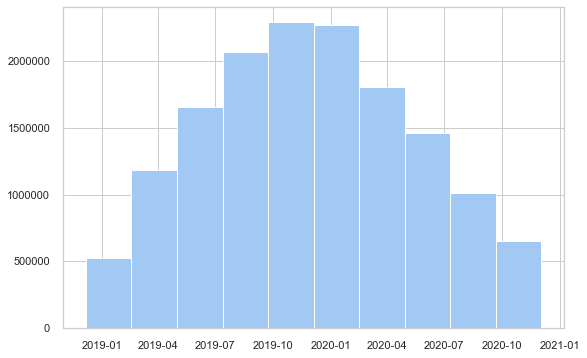

In [46]:
calendar.date.hist()

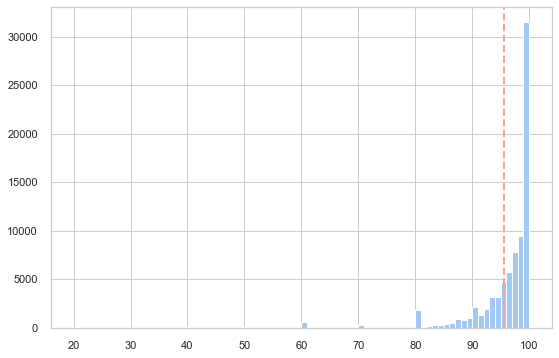

In [47]:
#plot hist
listings.review_scores_rating.hist(bins = 80)

#plot the mean
mean = np.mean(listings.review_scores_rating)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

Listings price

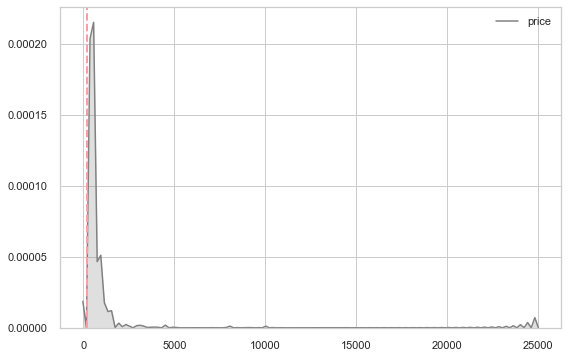

In [48]:
#KDE
ax = sns.kdeplot(listings.price, shade=True, color="grey")

#plot the mean
mean = np.mean(listings.price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

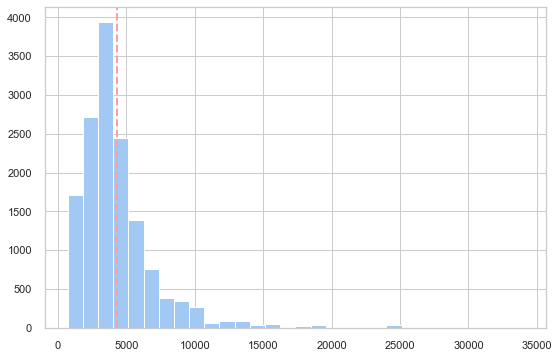

In [49]:
listings.monthly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.monthly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

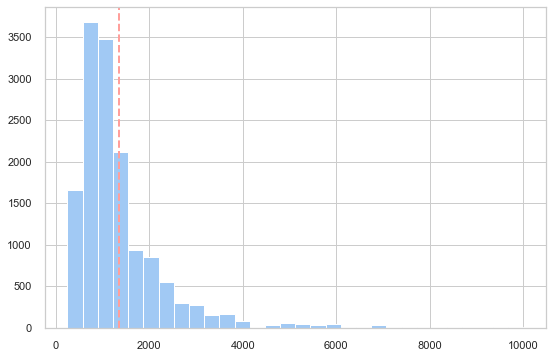

In [50]:
listings.weekly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.weekly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

#### Listings Outlier Removal for Price variable

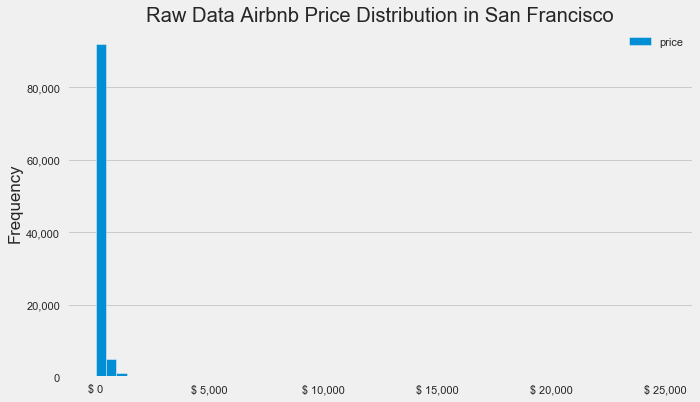

In [51]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Airbnb price distributions
listings.price.plot(kind = 'hist', bins=55,  title='Raw Data Airbnb Price Distribution in San Francisco',
          legend = True, figsize=(10,6));

#Get axis object
ax = plt.gca()

#Format axes
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,}".format(int(x))))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Mute grid lines
ax.grid(b=False, which ='major', axis = 'x')

#Set Path to write plot
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Output Files\Visualizations\Listings Data Distributions'

#Save plot to png
#plt.savefig(path + '\Listings Raw Data Price Distribution.png',bbox_inches = 'tight')

In [52]:
#Calculate IQR of price
q25 = listings['price'].quantile(0.25)
q75= listings['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in listings.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in listings.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
listings = listings[listings.price.isin(outliers_removed)]
print('Current listings shape:',listings.shape)

Percentiles: 25th=100.000, 75th=240.000 
IQR= 140.000
Number of outliers identified: 10025
Non-outlier observations: 88771
Current listings shape: (88771, 68)


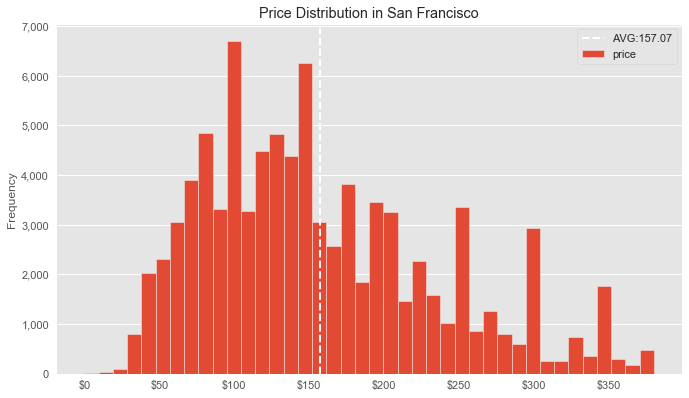

In [53]:
#Set ggplot plot style
plt.style.use('ggplot')

#Airbnb price distributions(outliers removed)
listings.price.plot(kind = 'hist', bins=40,  title='Price Distribution in San Francisco',
           figsize=(10,6));

#Capture mean and median of price
mean = listings.price.mean()
median = listings.price.median()

#Plot mean and median
plt.axvline(mean, color='white', linewidth=2, linestyle='--', label= 'AVG:'+ str(round(mean,2)))

#Get axis object
ax = plt.gca()

#Format axes
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Mute grid lines
plt.grid(b=False, which ='major', axis = 'x')

#Set legend
plt.legend(loc='upper right',frameon=True, fancybox=True)

#Save plot to png
#plt.savefig(path + '\Listings Data Price Distribution.png',bbox_inches = 'tight')

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

**Growth by neighborhood December 2018 - December 2019**

We'll merge our calendar data with listings data to capture neighborhood data

In [54]:
#Pull month and year date from date column
calendar['year']= pd.DatetimeIndex(calendar['date']).year
calendar['month']= pd.DatetimeIndex(calendar['date']).month

#Set dates
calendar= calendar[(calendar.year == 2018) | (calendar.year == 2019)]

#Drop unnecessary columns for merge to preserve memory
temp = calendar.drop(columns=['price','maximum_nights','minimum_nights',
                             'available'])

In [55]:
#capture listing id and neighbourhood_cleansed from listings for merge
neighborhoods = listings[['id', 'neighbourhood_cleansed']]

#Merge with calendar
neighborhood_growth = temp.merge(neighborhoods, left_on ='listing_id', right_on='id')

#Drop redundant columns
neighborhood_growth= neighborhood_growth.drop(columns = ['id'])

#Drop Dupes
neighborhood_growth.drop_duplicates(inplace=True)

In [56]:
#Group last year by month_year and get a count of unique listings per month
neighborhood_growth = neighborhood_growth.groupby(['neighbourhood_cleansed', 'year', 'month'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
neighborhood_growth =neighborhood_growth.rename(columns = {'neighbourhood_cleansed': 'neighborhoods',
                                                                 'nunique': 'listings'})

In [57]:
neighborhood_growth = neighborhood_growth.sort_values(by=['year','month', 'listings'], ascending=False)

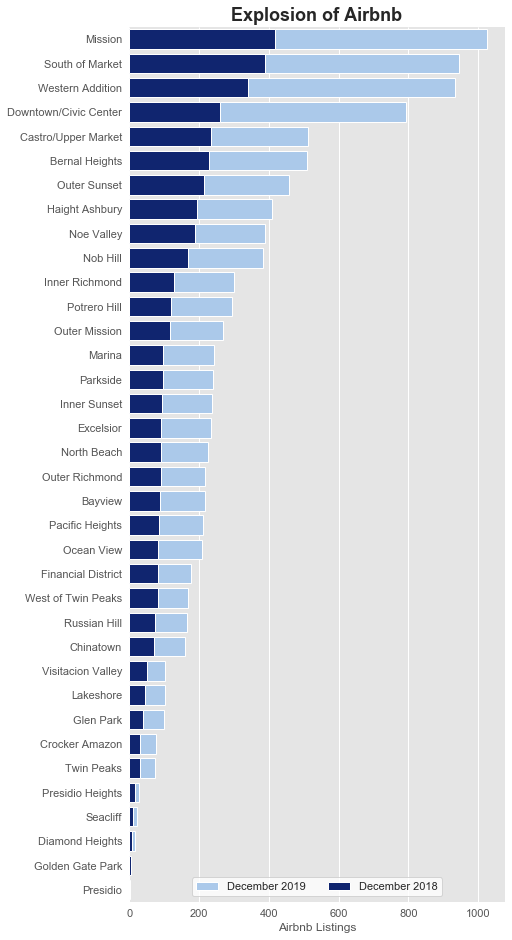

In [58]:
#Set fig size
f, ax = plt.subplots(figsize = (6,15))

#set style and color_pallete
sns.set(style='whitegrid')

#Set color codes for modern data
sns.set_color_codes('pastel')

#plot data from 
j = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth.loc[(neighborhood_growth.month == 12 ) & 
                                         (neighborhood_growth.year == 2019)],
                label = 'December 2019')

#Set color codes for older data
sns.set_color_codes('dark')

#Plot data from 2018-09
g = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth.loc[(neighborhood_growth.month == 12 ) & 
                                         (neighborhood_growth.year == 2018)],
                label = 'December 2018')

#Set legend info
ax.legend(frameon = True, ncol = 2, loc= 'lower center');

#Set Labels
ax.set(ylabel="", xlabel="Airbnb Listings")
ax.set_title('Explosion of Airbnb', fontweight = 'bold', fontsize = 18)


sns.despine(left=True, bottom=True)

#Set Path to write plot
#path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Output Files\Visualizations\Calendar Data Distributions'

#Save plot to png
#plt.savefig(path + '\Calendar Raw Data Distributions.png',bbox_inches = 'tight')


**Prices by property type**


Which neighborhoods are the nicest? Which are the safest? Refercne the review scores and location rating in listings

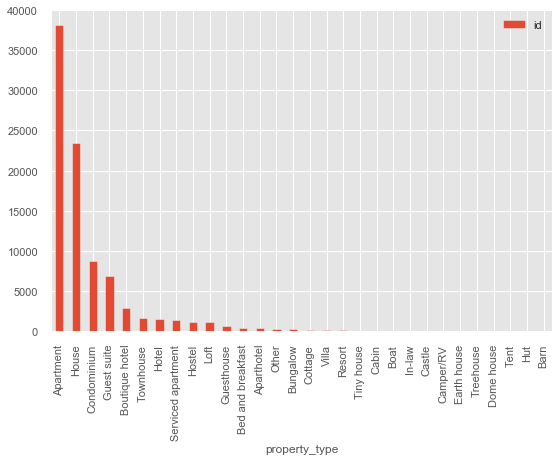

In [59]:
#Set 538 plot style
plt.style.use('ggplot')

#Counts of property types
prop_count = listings.groupby('property_type')['id'].count().sort_values(ascending = False).reset_index()
prop_count.plot(x = 'property_type', y = 'id', kind = 'bar')

In [60]:
#Get top 15 common prop types
prop_list=list(prop_count.property_type.head(15))

#sort top 15 by median value
test = listings[listings.property_type.isin(prop_list)].groupby('property_type')['price'].median().sort_values(ascending = False).reset_index()

In [61]:
test_list = test.property_type.tolist()

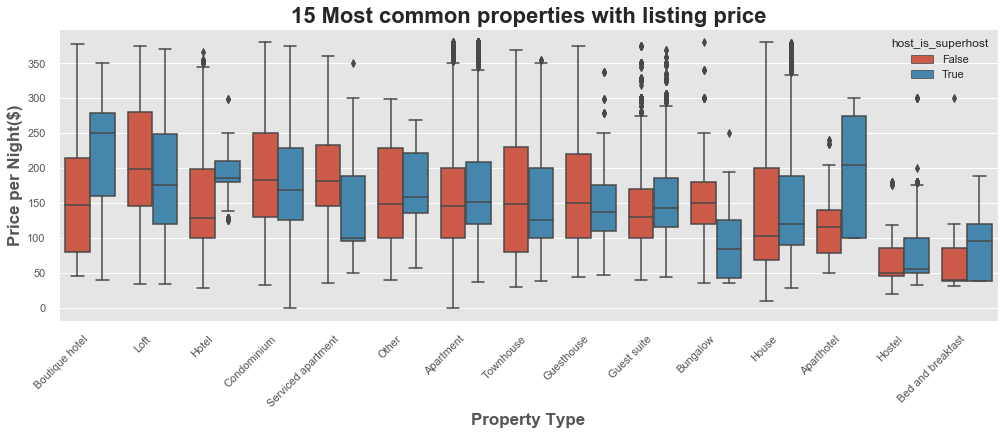

In [62]:
#Set 538 plot style
#plt.style.use('fivethirtyeight')

#Set Figure
f, ax = plt.subplots(figsize= (15,5))

#Plot
g= sns.boxplot(x="property_type", y="price",hue = 'host_is_superhost', order=test_list,
                data=listings[listings.property_type.isin(test_list)], ax=ax)

#Set Title
ax.set_title('15 Most common properties with listing price', fontweight = 'bold', fontsize=22)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y Labels
ax.set_ylabel('Price per Night($)',fontdict=fontdict)
ax.set_xlabel('Property Type',fontdict=fontdict)

#Rotate x_ticklabels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

#Format ticks on y-axis

**Heat map**

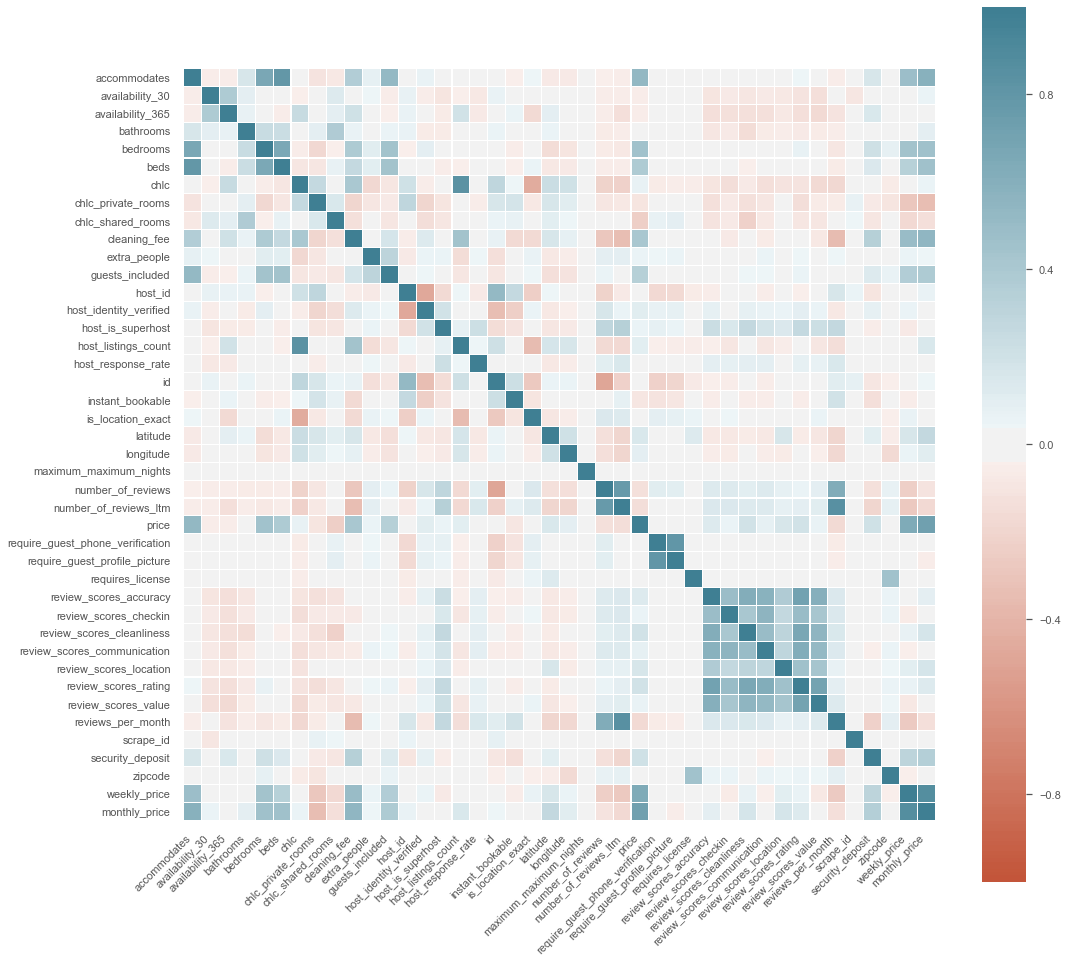

In [63]:
corr = listings.corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

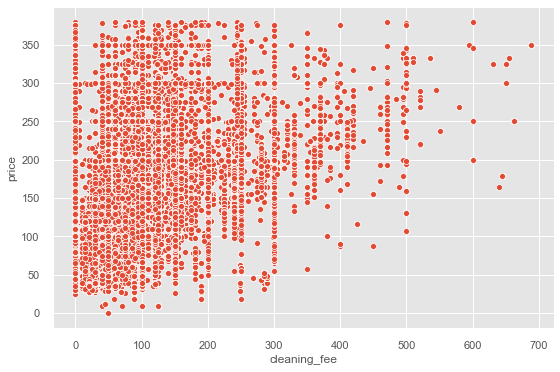

In [64]:
sns.scatterplot(x = 'cleaning_fee', y='price', data = listings)

#Superhost?

Explore what makes a super host.
Why would you want to be a super host
What advantages can you find to being a super host? (higher reviews, higher rent, more business?)

In [65]:
len(listings[listings.host_is_superhost == False])

52097

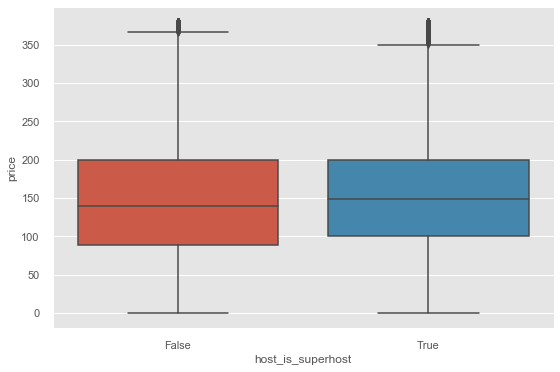

In [66]:
#Add values
sns.boxplot( x = 'host_is_superhost', y='price', data = listings)

Who owns the most Airbnb properties?

https://towardsdatascience.com/airbnb-rental-listings-dataset-mining-f972ed08ddec

In [67]:
len(listings[listings.host_is_superhost == False])

52097

In [68]:
test = listings.groupby(['host_id'])['id'].agg({'nunique'}).sort_values(by ='nunique', ascending =False).reset_index()

#Get a list of the properties owned by the top host ids
test_list = list(test.host_id.head(10))#might be worth doing more than 10, maybe anything more than listing id1?
#would differentitate the average host? Perhaps calculate aberage lisitng ids per host and get the outliers?

#get the listings data
listings[listings.host_id.isin(test_list)].head(10).T

,2316,2539,2568,2627,2637,2682,2730,2774,2836,2857
accommodates,4,3,2,4,2,2,3,2,2,2
amenities,TV Cable TV Internet Wifi Kitchen Free str...,TV Internet Wifi Kitchen Heating Smoke detec...,TV Cable TV Internet Wifi Kitchen Elevator ...,TV Cable TV Internet Wifi Air conditioning...,TV Internet Wifi Elevator Heating Washer Drye...,TV Internet Wifi Kitchen Heating Smoke detec...,TV Internet Wifi Kitchen Heating Washer Dryer...,TV Internet Wifi Kitchen Elevator Heating Was...,TV Cable TV Air conditioning Paid parkin...,TV Internet Wifi Kitchen Elevator Heating Was...
availability_30,0,0,0,0,2,0,29,0,0,0
availability_365,329,139,116,277,14,15,89,25,0,31
bathrooms,2,1,1,2,1,1,1,1,1,1
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
bedrooms,2,1,0,2,0,0,1,0,0,0
beds,2,2,1,2,1,1,1,1,1,1
chlc,216,87,87,216,87,87,87,87,20,87
chlc_private_rooms,0,1,1,0,1,1,1,1,1,1


When is the cheapest days for travel? How do prices compare during holiday>

In [70]:
#Set path to write listings
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed\01_16_2020_Listings_Post_EDA.csv'

#Write listings to path
listings.to_csv(path, sep=',')